In [0]:
#from google.colab import files
#files.upload()

In [44]:
%%time
from __future__ import absolute_import, division, unicode_literals, print_function
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

import cv2
import pathlib
from scipy import stats
from tqdm import tqdm_notebook, tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(12,10)})
sns.set_style("whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import os
import gc
gc.enable()
import sys
import csv
import time
import json
import glob
import datetime
import random
import subprocess
import functools
import multiprocessing
from multiprocessing import Pool

np.set_printoptions(precision=3, suppress=True)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

try:
  %tensorflow_version 2.x
  print("TensorFlow 2.0 rc is up and running.")
except:
  print("TensorFlow 2.0 rc error.!")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.preprocessing import *

print("TensorFlow version: ",tf.__version__)
print("Exeuting eagerly: ",tf.executing_eagerly())
print("GPU is","available." if tf.test.is_gpu_available() else "unavailable.")

from IPython.display import display, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def seed_everything(seed):
  try:
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print("Seeding intialized.")
  except:
    print("Seeding faled.")

seed_everything(999)
print(os.listdir())
print("Done.!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow 2.0 rc is up and running.
TensorFlow version:  2.2.0
Exeuting eagerly:  True
GPU is available.
Seeding intialized.
['.config', 'model.png', 'model_regressor.h5', 'submission_format.csv', 'sample_data']
Done.!
CPU times: user 22.3 ms, sys: 9.16 ms, total: 31.5 ms
Wall time: 32.8 ms


# New Section

In [0]:
def display_all(df):
  with pd.option_context("display.max_rows",1000,"display.max_columns",50):
    display(df)

### display data

In [46]:
train_features = pd.read_csv('https://raw.githubusercontent.com/suvodeepdebnath/suvodeepdebnath123-gmail.com/master/dengue_features_train.csv')
test_features = pd.read_csv('https://raw.githubusercontent.com/suvodeepdebnath/suvodeepdebnath123-gmail.com/master/dengue_features_test.csv')
train_labels = pd.read_csv('https://raw.githubusercontent.com/suvodeepdebnath/suvodeepdebnath123-gmail.com/master/dengue_labels_train.csv')

display_all(train_features)
display_all(test_features)
display_all(train_labels)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
5,sj,2008,23,2008-06-03,-0.044000,-0.030467,0.132000,0.083529,71.17,299.768571,299.728571,295.314286,301.9,297.6,22.55,76.557143,71.17,16.667143,2.857143,28.000000,5.171429,32.8,25.0,27.7
6,sj,2008,24,2008-06-10,-0.044300,-0.024925,0.132271,0.159157,48.99,300.062857,300.007143,295.650000,302.4,297.5,13.10,76.844286,48.99,17.010000,3.157143,27.400000,6.042857,31.1,23.3,91.7
7,sj,2008,25,2008-06-17,NaN,0.082150,0.144371,0.116729,30.81,300.484286,300.578571,295.997143,303.5,297.5,7.20,76.870000,30.81,17.420000,3.900000,28.757143,6.985714,34.4,24.4,0.3
8,sj,2008,26,2008-06-24,0.010800,0.049900,0.100571,0.117329,8.02,300.601429,300.621429,296.268571,302.5,298.5,17.10,77.395714,8.02,17.678571,2.785714,28.657143,6.242857,32.8,23.9,28.7
9,sj,2008,27,2008-07-01,0.072667,0.106660,0.155429,0.164900,17.52,300.497143,300.528571,296.411429,302.3,298.7,11.90,78.534286,17.52,17.808571,2.228571,28.457143,4.628571,31.1,25.0,2.9


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


### Check for null values

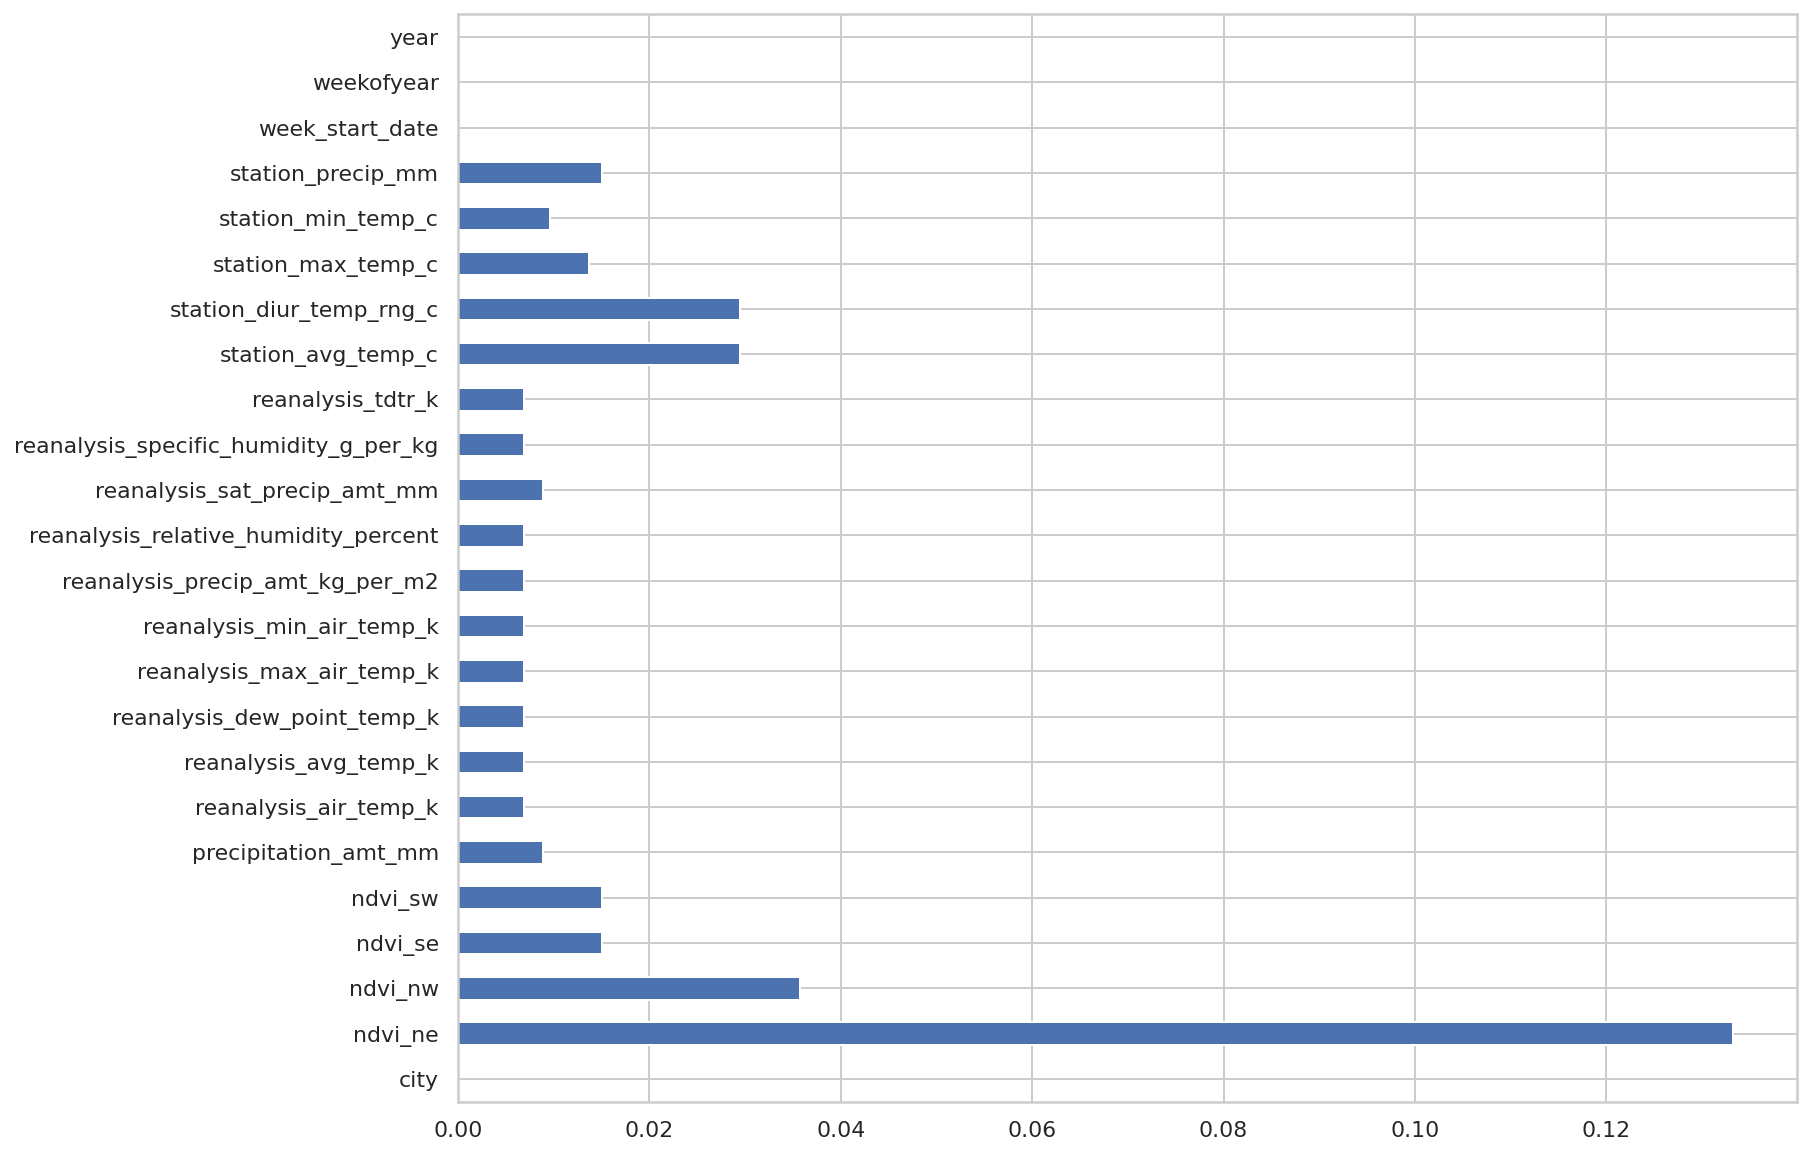

In [47]:
pd.DataFrame(train_features.isnull().sum().sort_index()/len(train_features))[0].plot(kind="barh",figsize=(12,10))

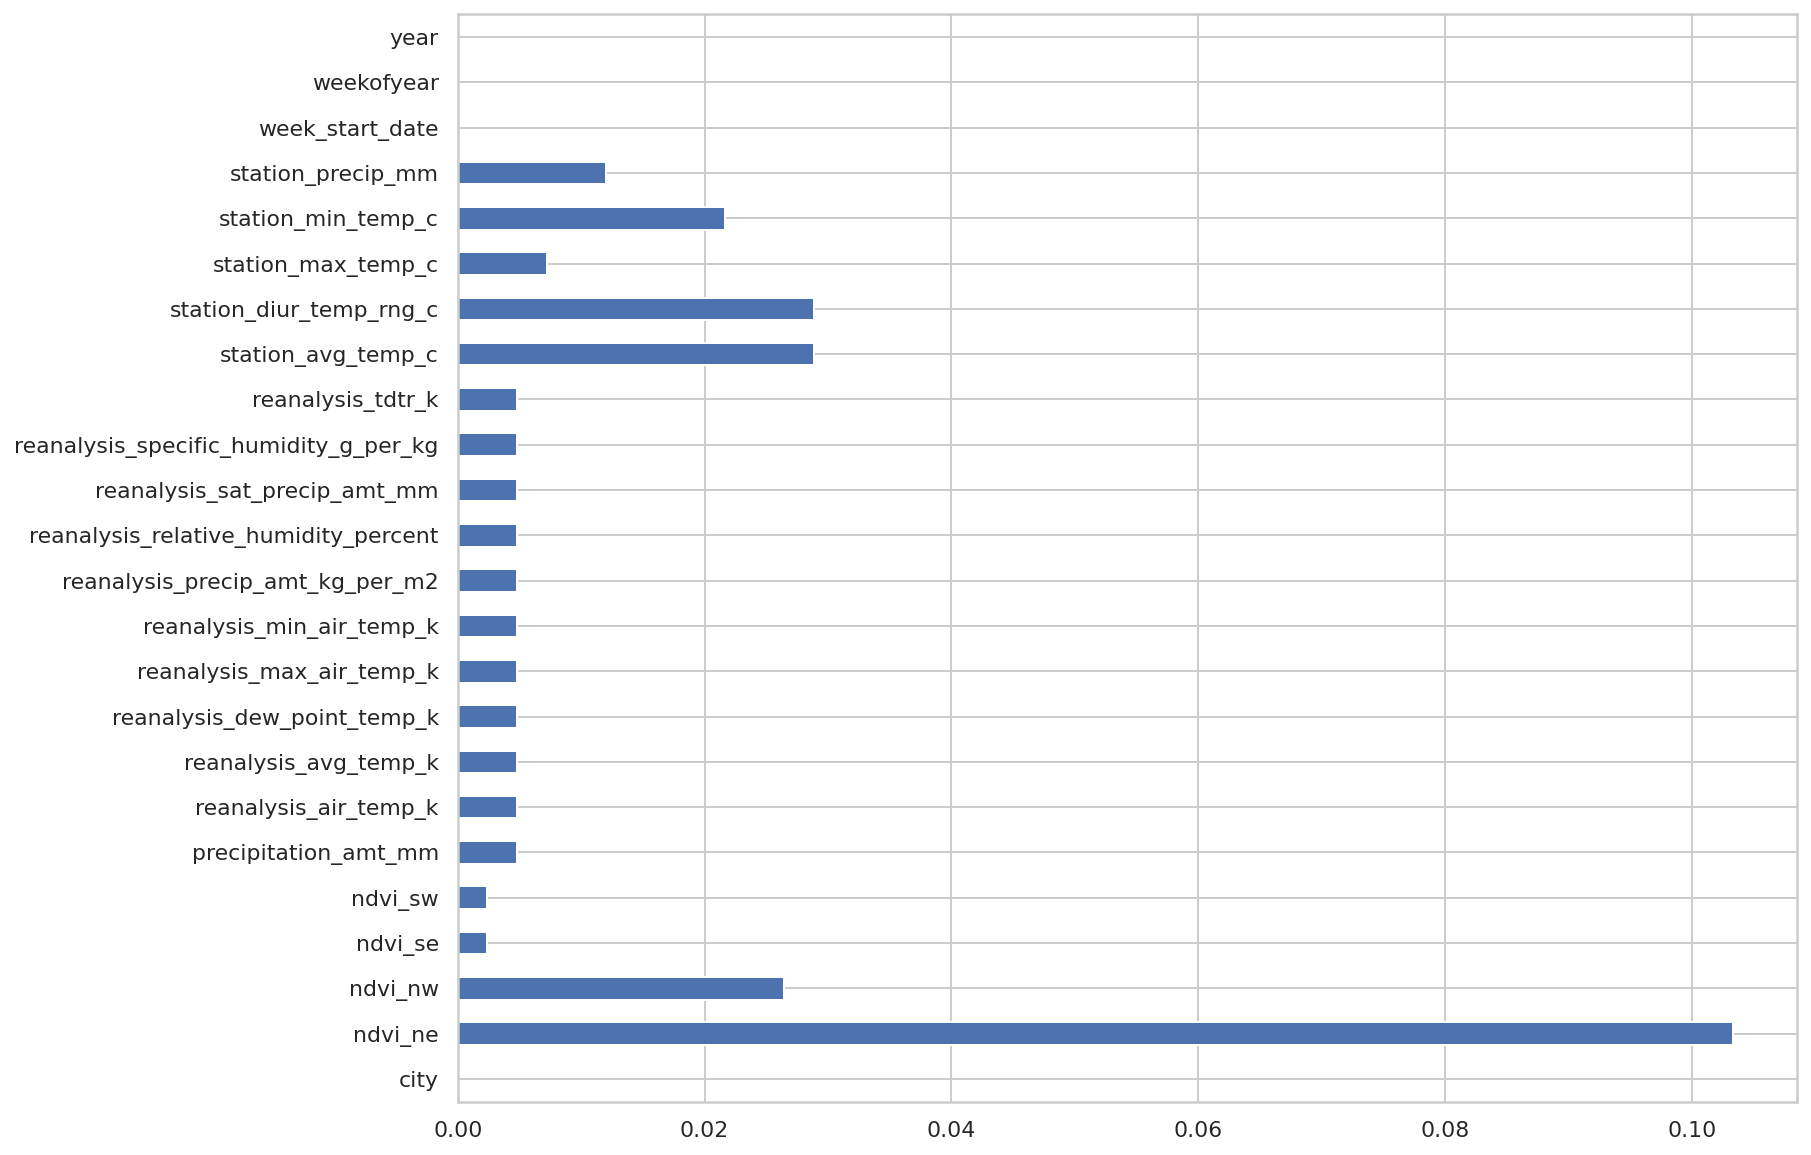

In [48]:
pd.DataFrame(test_features.isnull().sum().sort_index()/len(test_features))[0].plot(kind="barh",figsize=(12,10))

### data description and info

In [49]:
display_all(train_features.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,1456,2,sj,936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,1456,NaN,NaN,NaN,2001.03,5.40831,1990,1997,2002,2005,2010
weekofyear,1456,NaN,NaN,NaN,26.5034,15.0194,1,13.75,26.5,39.25,53
week_start_date,1456,1049,2001-02-26,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ndvi_ne,1262,NaN,NaN,NaN,0.142294,0.140531,-0.40625,0.04495,0.128817,0.248483,0.508357
ndvi_nw,1404,NaN,NaN,NaN,0.130553,0.119999,-0.4561,0.0492167,0.121429,0.2166,0.454429
ndvi_se,1434,NaN,NaN,NaN,0.203783,0.0738597,-0.0155333,0.155087,0.19605,0.248846,0.538314
ndvi_sw,1434,NaN,NaN,NaN,0.202305,0.0839027,-0.0634571,0.144209,0.18945,0.246982,0.546017
precipitation_amt_mm,1443,NaN,NaN,NaN,45.7604,43.7155,0,9.8,38.34,70.235,390.6
reanalysis_air_temp_k,1446,NaN,NaN,NaN,298.702,1.36242,294.636,297.659,298.646,299.834,302.2


In [50]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

In [51]:
train_features.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [52]:
display_all(test_features.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,416,2,sj,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,416,NaN,NaN,NaN,2010.77,1.43484,2008,2010,2011,2012,2013
weekofyear,416,NaN,NaN,NaN,26.4399,14.9783,1,13.75,26,39,53
week_start_date,416,269,2011-11-26,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ndvi_ne,373,NaN,NaN,NaN,0.12605,0.164353,-0.4634,-0.0015,0.1101,0.263329,0.5004
ndvi_nw,405,NaN,NaN,NaN,0.126803,0.14142,-0.2118,0.015975,0.0887,0.2424,0.649
ndvi_se,415,NaN,NaN,NaN,0.207702,0.0791019,0.0062,0.14867,0.204171,0.254871,0.453043
ndvi_sw,415,NaN,NaN,NaN,0.201721,0.0920276,-0.0146714,0.134079,0.186471,0.253243,0.529043
precipitation_amt_mm,414,NaN,NaN,NaN,38.3543,35.1711,0,8.175,31.455,57.7725,169.34
reanalysis_air_temp_k,414,NaN,NaN,NaN,298.818,1.4695,294.554,297.751,298.547,300.24,301.936


In [53]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   416 non-null    object 
 1   year                                   416 non-null    int64  
 2   weekofyear                             416 non-null    int64  
 3   week_start_date                        416 non-null    object 
 4   ndvi_ne                                373 non-null    float64
 5   ndvi_nw                                405 non-null    float64
 6   ndvi_se                                415 non-null    float64
 7   ndvi_sw                                415 non-null    float64
 8   precipitation_amt_mm                   414 non-null    float64
 9   reanalysis_air_temp_k                  414 non-null    float64
 10  reanalysis_avg_temp_k                  414 non-null    float64
 11  reanal

In [54]:
test_features.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

### checking memory usage and total records

In [55]:
csv_files = [train_features, train_labels, test_features]
print("Total memory usage by {} is : {:.2}MB".format(csv_files[0],train_features.memory_usage().sum()/1024**2))
print("Total memory usage by {} is : {:.2}MB".format(csv_files[1],train_labels.memory_usage().sum()/1024**2))
print("Total memory usage by {} is : {:.2}MB".format(csv_files[2],test_features.memory_usage().sum()/1024**2))

Total memory usage by      city  year  ...  station_min_temp_c station_precip_mm
0      sj  1990  ...                20.0              16.0
1      sj  1990  ...                22.2               8.6
2      sj  1990  ...                22.8              41.4
3      sj  1990  ...                23.3               4.0
4      sj  1990  ...                23.9               5.8
...   ...   ...  ...                 ...               ...
1451   iq  2010  ...                22.4              27.0
1452   iq  2010  ...                21.7              36.6
1453   iq  2010  ...                19.2               7.4
1454   iq  2010  ...                21.0              16.0
1455   iq  2010  ...                22.2              20.4

[1456 rows x 24 columns] is : 0.27MB
Total memory usage by      city  year  weekofyear  total_cases
0      sj  1990          18            4
1      sj  1990          19            5
2      sj  1990          20            4
3      sj  1990          21            3
4    

In [56]:
print("Train features shape: ", train_features.shape)
print("Train labels shape: ", train_labels.shape)
print("Test features shape: ", test_features.shape)

Train features shape:  (1456, 24)
Train labels shape:  (1456, 4)
Test features shape:  (416, 24)


### very simple preprocessing and feature engineering

In [57]:
print("Before dropping: ", len(train_features.columns))
threshold = 0.3

#Dropping columns with missing value rate higher than threshold
train_features = train_features[train_features.columns[train_features.isnull().mean() < threshold]]
print("Afer dropping: ",len(train_features.columns))

Before dropping:  24
Afer dropping:  24


In [0]:
# filling nan values
numeric_columns = [i for i in train_features.columns if train_features[i].dtype=="float64"]
train_features[numeric_columns] = train_features[numeric_columns].fillna(999)

In [59]:
train_features.head(2)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6


In [60]:
## one - hot encoding
encoded_columns = pd.get_dummies(train_features['city'])
train_features = train_features.join(encoded_columns).drop('city', axis=1)
train_features.head(2)

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,1990,18,1990-04-30,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,0,1
1,1990,19,1990-05-07,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,0,1


In [61]:
# feature scaling
sc = StandardScaler()
train_features[numeric_columns] = sc.fit_transform(train_features[numeric_columns])
train_features.head(2)

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,1990,18,1990-04-30,-0.392135,-0.192595,-0.123905,-0.124064,-0.419917,-0.102652,-0.108790,-0.131841,-0.146069,-0.079969,-0.163311,-0.198450,-0.419917,-0.116836,-0.110770,-0.185035,-0.181343,-0.145126,-0.120568,-0.299780,0,1
1,1990,19,1990-05-07,-0.391995,-0.192387,-0.124202,-0.124246,-0.315568,-0.091614,-0.096681,-0.105403,-0.126951,-0.071369,-0.319116,-0.145819,-0.315568,-0.100074,-0.113899,-0.177307,-0.184494,-0.124685,-0.097493,-0.358425,0,1


In [62]:
#convert timestamp format back to str
#train_features["week_start_date"] = train_features["week_start_date"].astype("str")

#removing datetime column for brevity
train_features.pop("week_start_date")

0       1990-04-30
1       1990-05-07
2       1990-05-14
3       1990-05-21
4       1990-05-28
           ...    
1451    2010-05-28
1452    2010-06-04
1453    2010-06-11
1454    2010-06-18
1455    2010-06-25
Name: week_start_date, Length: 1456, dtype: object

In [63]:
train_features.head(2)

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,1990,18,-0.392135,-0.192595,-0.123905,-0.124064,-0.419917,-0.102652,-0.108790,-0.131841,-0.146069,-0.079969,-0.163311,-0.198450,-0.419917,-0.116836,-0.110770,-0.185035,-0.181343,-0.145126,-0.120568,-0.299780,0,1
1,1990,19,-0.391995,-0.192387,-0.124202,-0.124246,-0.315568,-0.091614,-0.096681,-0.105403,-0.126951,-0.071369,-0.319116,-0.145819,-0.315568,-0.100074,-0.113899,-0.177307,-0.184494,-0.124685,-0.097493,-0.358425,0,1


In [64]:
X = train_features.copy()
y = train_labels.pop("total_cases")

print(X.head(2))
print(y.head(2))

gc.collect()

   year  weekofyear   ndvi_ne  ...  station_precip_mm  iq  sj
0  1990          18 -0.392135  ...          -0.299780   0   1
1  1990          19 -0.391995  ...          -0.358425   0   1

[2 rows x 24 columns]
0    4
1    5
Name: total_cases, dtype: int64


33103

### Creating a predictive model from tensorflow and keras

In [0]:
def create_model():
  model = tf.keras.Sequential([
                               layers.Dense(256,activation=tf.nn.relu,use_bias=True,kernel_initializer="he_uniform",kernel_regularizer=keras.regularizers.l2(0.001),input_shape=[len(X.keys())]),
                               layers.BatchNormalization(),
                               layers.Dropout(0.4),
                               layers.Dense(128,activation=tf.nn.relu,use_bias=True,kernel_initializer="he_uniform",kernel_regularizer=keras.regularizers.l2(0.001)),
                               layers.BatchNormalization(),
                               layers.Dropout(0.4),
                               layers.Dense(64,activation=tf.nn.relu,kernel_initializer="he_uniform",kernel_regularizer=keras.regularizers.l2(0.001),use_bias=True),
                               layers.BatchNormalization(),
                               layers.Dropout(0.4),
                               layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="mean_squared_error",metrics=["mean_absolute_error","mean_squared_error"])

  model.summary()

  return model

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_regressor.h5",monitor="val_loss",verbose=1,save_best_only=True,mode="auto")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.3,patience=5,verbose=1,mode="auto",min_lr=0.000001)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",verbose=1,mode="auto", patience=40)

In [0]:
class PlotLearning(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.loss = []
    self.val_loss = []
    self.mae = []
    self.val_mae = []
    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
      
    self.logs.append(logs)
    self.x.append(self.i)
    self.loss.append(logs.get('loss'))
    self.mae.append(logs.get('mean_absolute_error'))
    self.val_loss.append(logs.get('val_loss'))        
    self.val_mae.append(logs.get('val_mean_absolute_error'))
    self.i += 1
    f, ax = plt.subplots(1, 2, figsize=(18,6), sharex=True)
    ax = ax.flatten()
    clear_output(wait=True)

    ax[0].plot(self.x, self.loss, label="Mean Squared Error", lw=2)
    ax[0].plot(self.x, self.val_loss, label="Val Mean Squared Error")
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(self.x, self.mae, label="Mean Absolute Error", lw=2)
    ax[1].plot(self.x, self.val_mae, label="Val Mean Absolute Error")
    ax[1].legend()
    ax[1].grid(True)
      
    plt.show();
        
plotLoss = PlotLearning()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               6400      
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

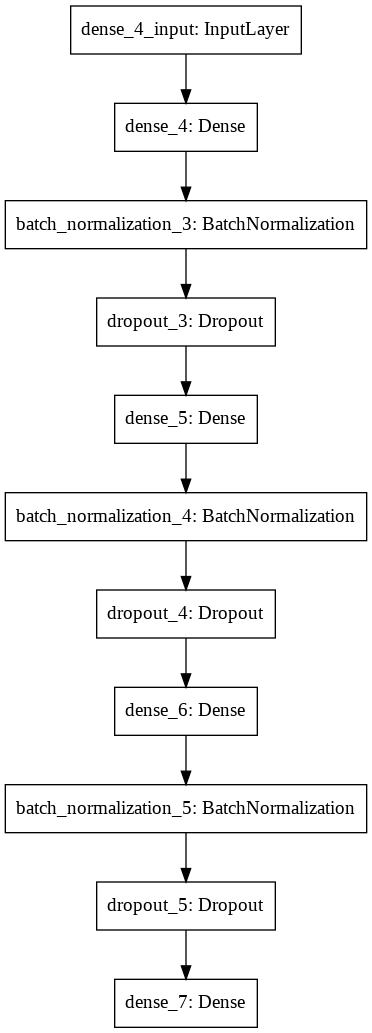

In [68]:
regressor = create_model()
plot_model(regressor)

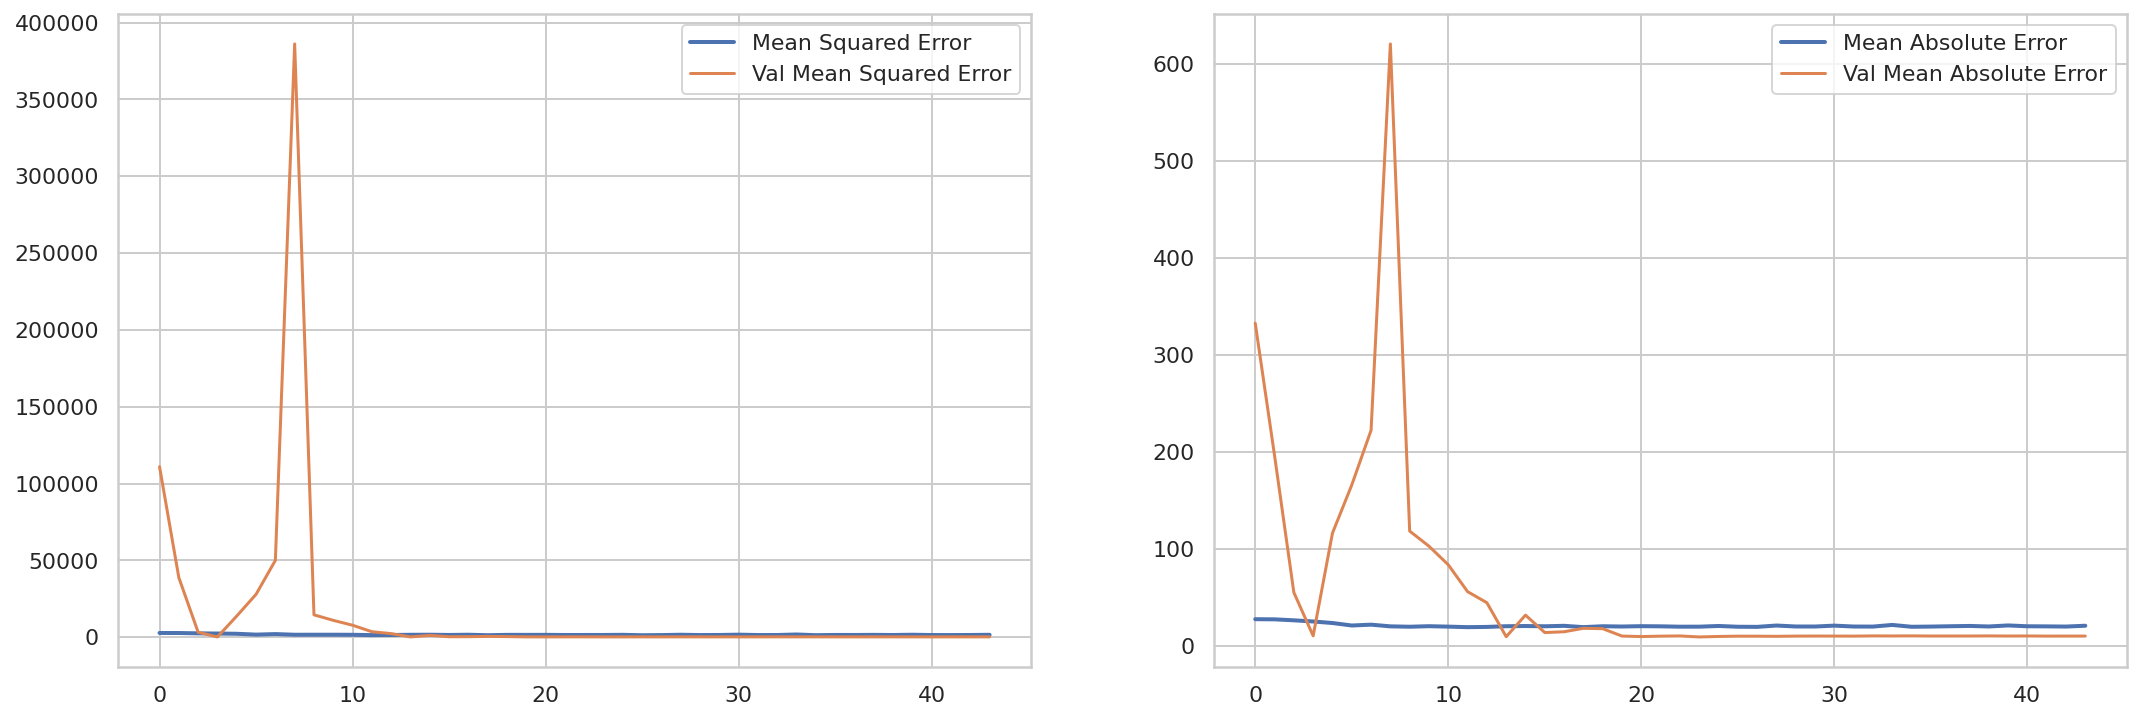


Epoch 00044: val_loss did not improve from 232.93675
91/91 [==============================] - 1s 16ms/step - loss: 1626.1453 - mean_absolute_error: 21.0983 - mean_squared_error: 1625.4136 - val_loss: 285.6846 - val_mean_absolute_error: 10.4558 - val_mean_squared_error: 284.9532 - lr: 1.0000e-06
Epoch 00044: early stopping


In [69]:
EPOCHS = 5000
#%tensorboard --logdir logs
history = regressor.fit(X, y, epochs=EPOCHS, steps_per_epoch=X.shape[0]/16, batch_size=16, validation_split=0.2, verbose=1, callbacks=[reduce_lr,plotLoss,checkpoint,early_stopping])

In [70]:
loss, mae, mse = regressor.evaluate(X, y, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

46/46 - 0s - loss: 957.6182 - mean_absolute_error: 15.6926 - mean_squared_error: 956.8868
Testing set Mean Abs Error: 15.69 MPG


In [71]:
regressor.predict(X)

array([[20.136],
       [19.719],
       [19.197],
       ...,
       [ 2.738],
       [ 3.312],
       [ 3.849]], dtype=float32)

In [72]:
train_labels

,city,year,weekofyear
0,sj,1990,18
1,sj,1990,19
2,sj,1990,20
3,sj,1990,21
4,sj,1990,22
...,...,...,...
1451,iq,2010,21
1452,iq,2010,22
1453,iq,2010,23
1454,iq,2010,24


**Simple Preprocessing and feature engineering of test_feature**

In [73]:
print("Before dropping: ", len(test_features.columns))
threshold = 0.3

#Dropping columns with missing value rate higher than threshold
test_features = test_features[test_features.columns[test_features.isnull().mean() < threshold]]
print("Afer dropping: ",len(test_features.columns))

Before dropping:  24
Afer dropping:  24


In [0]:
# filling nan values
numeric_columns = [i for i in test_features.columns if test_features[i].dtype=="float64"]
test_features[numeric_columns] = test_features[numeric_columns].fillna(999)

In [75]:
## one - hot encoding
encoded_columns = pd.get_dummies(test_features['city'])
test_features = test_features.join(encoded_columns).drop('city', axis=1)
test_features.head(2)

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,2008,18,2008-04-29,-0.0189,-0.0189,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0,1
1,2008,19,2008-05-06,-0.0180,-0.0124,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,0,1


In [76]:
# feature scaling
sc = StandardScaler()
test_features[numeric_columns] = sc.fit_transform(test_features[numeric_columns])
test_features.head(2)

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,2008,18,2008-04-29,-0.340008,-0.165713,-0.051234,-0.051348,0.474250,-0.076189,-0.086068,-0.087791,-0.121716,-0.055919,-0.260386,-0.127306,0.474250,-0.084329,-0.098409,-0.177512,-0.176871,-0.075849,-0.153399,0.265122,0,1
1,2008,19,2008-05-06,-0.340005,-0.165673,-0.051657,-0.051734,-0.404839,-0.076543,-0.085920,-0.090491,-0.127941,-0.049762,-0.303457,-0.135946,-0.404839,-0.086200,-0.106503,-0.180323,-0.185912,-0.116191,-0.149880,-0.104633,0,1


In [77]:
#convert timestamp format back to str
#train_features["week_start_date"] = train_features["week_start_date"].astype("str")

#removing datetime column for brevity
test_features.pop("week_start_date")

0      2008-04-29
1      2008-05-06
2      2008-05-13
3      2008-05-20
4      2008-05-27
          ...    
411    2013-05-28
412    2013-06-04
413    2013-06-11
414    2013-06-18
415    2013-06-25
Name: week_start_date, Length: 416, dtype: object

In [78]:
train_features

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,1990,18,-0.392135,-0.192595,-0.123905,-0.124064,-0.419917,-0.102652,-0.108790,-0.131841,-0.146069,-0.079969,-0.163311,-0.198450,-0.419917,-0.116836,-0.110770,-0.185035,-0.181343,-0.145126,-0.120568,-0.299780,0,1
1,1990,19,-0.391995,-0.192387,-0.124202,-0.124246,-0.315568,-0.091614,-0.096681,-0.105403,-0.126951,-0.071369,-0.319116,-0.145819,-0.315568,-0.100074,-0.113899,-0.177307,-0.184494,-0.124685,-0.097493,-0.358425,0,1
2,1990,20,-0.392401,-0.192221,-0.124244,-0.124120,-0.197976,-0.081762,-0.089143,-0.079900,-0.133903,-0.055889,-0.228691,-0.084229,-0.197976,-0.081886,-0.114768,-0.177307,-0.183813,-0.120241,-0.091200,-0.098484,0,1
3,1990,21,-0.392117,-0.191832,-0.123666,-0.123586,-0.390418,-0.078206,-0.083089,-0.082037,-0.118261,-0.061049,-0.363885,-0.106788,-0.390418,-0.084052,-0.113203,-0.172705,-0.182110,-0.110465,-0.085956,-0.394880,0,1
4,1990,22,-0.391918,-0.191740,-0.123472,-0.123492,-0.469081,-0.069020,-0.075551,-0.073241,-0.109571,-0.052449,-0.382724,-0.105172,-0.469081,-0.077432,-0.106076,-0.163762,-0.166613,-0.095356,-0.079663,-0.380615,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2010,21,-0.391486,-0.191434,-0.123430,-0.123121,0.010320,-0.072206,-0.056399,-0.055968,0.025994,-0.104049,-0.019252,0.004034,0.010320,-0.061709,-0.023502,-0.165643,-0.151343,-0.091801,-0.095396,-0.212604,1,0
1452,2010,22,-0.392024,-0.192289,-0.124418,-0.123670,0.323064,-0.089565,-0.080247,-0.062381,0.005138,-0.148769,1.777051,0.041300,0.323064,-0.066833,-0.051838,-0.172937,-0.159886,-0.098022,-0.102738,-0.136524,1,0
1453,2010,23,-0.391768,-0.192366,-0.123479,-0.123604,0.046842,-0.119493,-0.111385,-0.078745,-0.047003,-0.140169,0.042804,0.076537,0.046842,-0.079914,-0.051490,-0.191374,-0.181343,-0.120241,-0.128958,-0.367935,1,0
1454,2010,24,-0.391512,-0.191828,-0.123245,-0.122851,0.054166,-0.123864,-0.112620,-0.081791,-0.036575,-0.148769,0.172790,0.081534,0.054166,-0.082291,-0.046970,-0.185093,-0.170416,-0.129129,-0.110079,-0.299780,1,0


In [79]:
test_features

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
0,2008,18,-0.340008,-0.165713,-0.051234,-0.051348,0.474250,-0.076189,-0.086068,-0.087791,-0.121716,-0.055919,-0.260386,-0.127306,0.474250,-0.084329,-0.098409,-0.177512,-0.176871,-0.075849,-0.153399,0.265122,0,1
1,2008,19,-0.340005,-0.165673,-0.051657,-0.051734,-0.404839,-0.076543,-0.085920,-0.090491,-0.127941,-0.049762,-0.303457,-0.135946,-0.404839,-0.086200,-0.106503,-0.180323,-0.185912,-0.116191,-0.149880,-0.104633,0,1
2,2008,20,-0.339951,6.067796,-0.050246,-0.051341,-0.523312,-0.056318,-0.069396,-0.071743,-0.098894,-0.055919,-0.518932,-0.135320,-0.523312,-0.073207,-0.079524,-0.168904,-0.172480,-0.081961,-0.145657,-0.387599,0,1
3,2008,21,2.945236,-0.165720,-0.050793,-0.050643,-0.572032,-0.051483,-0.061723,-0.090344,-0.082296,-0.045657,-0.542292,-0.217650,-0.572032,-0.086431,-0.080769,-0.168113,-0.181606,-0.075849,-0.134398,-0.412008,0,1
4,2008,22,-0.339759,-0.165347,-0.052061,-0.051660,-0.561915,-0.049625,-0.062904,-0.083009,-0.096819,-0.037447,-0.516012,-0.200906,-0.561915,-0.081112,-0.092391,-0.170836,-0.176699,-0.075849,-0.142139,0.345583,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2013,22,-0.338954,-0.163224,-0.047597,-0.045378,-0.024664,-0.091019,-0.077510,-0.064965,-0.030428,-0.131860,0.253420,0.048323,-0.024664,-0.065680,0.002864,-0.172154,-0.164860,-0.084406,-0.152695,-0.116385,1,0
412,2013,23,-0.339132,-0.163746,-0.047500,-0.046049,0.380005,-0.103550,-0.090642,-0.060711,-0.013830,-0.154436,-0.013034,0.109455,0.380005,-0.061812,-0.003569,-0.171416,-0.154794,-0.069736,-0.155510,0.200031,1,0
413,2013,24,-0.339161,-0.164029,-0.048170,-0.048106,0.479043,-0.131116,-0.126199,-0.080251,-0.049100,-0.172908,-0.018874,0.126310,0.479043,-0.077097,-0.036566,-0.173383,-0.158682,-0.084406,-0.154102,0.427851,1,0
414,2013,25,-0.338925,-0.163707,-0.045021,-0.044954,-0.045696,-0.132207,-0.109822,-0.105835,-0.022129,-0.135964,-0.511875,0.033706,-0.045696,-0.095829,-0.024322,-0.176458,-0.168295,-0.089296,-0.152695,-0.106441,1,0


In [80]:
submission_format = pd.read_csv('https://raw.githubusercontent.com/suvodeepdebnath/suvodeepdebnath123-gmail.com/master/submission_format.csv')
submission_format

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0
...,...,...,...,...
411,iq,2013,22,0
412,iq,2013,23,0
413,iq,2013,24,0
414,iq,2013,25,0


In [81]:
X = test_features.copy()
predict_y = regressor.predict (X)

for i in range(0, 416):
  if predict_y[i] < 0:
    predict_y[i] = 0

predict_y

array([[  6.214],
       [  7.07 ],
       [ 11.544],
       [  8.56 ],
       [  9.739],
       [ 13.094],
       [ 13.101],
       [ 14.857],
       [ 18.21 ],
       [ 21.121],
       [ 22.894],
       [ 28.824],
       [ 27.62 ],
       [ 28.97 ],
       [ 29.763],
       [ 32.829],
       [ 29.732],
       [ 32.521],
       [ 29.343],
       [ 29.516],
       [ 28.267],
       [ 28.209],
       [ 27.338],
       [ 26.533],
       [ 26.031],
       [ 26.56 ],
       [ 25.002],
       [ 25.001],
       [ 24.604],
       [ 23.812],
       [ 23.686],
       [ 23.103],
       [ 22.863],
       [ 22.511],
       [ 22.23 ],
       [ 60.631],
       [  3.677],
       [  3.329],
       [  3.155],
       [  2.805],
       [  2.753],
       [  2.586],
       [  2.918],
       [  2.936],
       [  3.678],
       [  3.942],
       [  3.274],
       [  3.761],
       [  4.057],
       [  4.559],
       [  5.182],
       [  5.563],
       [  6.764],
       [  7.851],
       [  9.318],
       [ 1

In [82]:
for i in range(0, 416):
  submission_format.at[i, 'total_cases'] = predict_y[i]

submission_format

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,7
2,sj,2008,20,11
3,sj,2008,21,8
4,sj,2008,22,9
...,...,...,...,...
411,iq,2013,22,3
412,iq,2013,23,4
413,iq,2013,24,4
414,iq,2013,25,5


In [0]:
submission_format.to_csv('submission_format.csv')
from google.colab import files
files.download("submission_format.csv")